In [1]:
import numpy as np
import pandas as pd
import xarray as xr
#import dask
import matplotlib.pyplot as plt
import utils
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2
import time
import joblib
from scipy.stats import gaussian_kde
import datetime
import shap
import os

In [2]:
# define data paths
#fn =  'C:\\Users\\hopki\\Projects\\gosat_oco2\\match_gosat_v9_oco2_v11.1_20140906_20200630_time2_lat2_lon3_min3_dist300_max100_closest.nc' 
#fn = 'C:\\Users\\hopki\\Projects\\gosat_oco2\\match_gosat_v9_oco2_v11.1_20140906_20200630_time1_lat2_lon3_min3_dist100.nc' 
#fn = 'C:\\Users\\hopki\\Projects\\gosat_oco2\\match_gosat_v9_oco2_v11.1_20140906_20200630_time1_lat2_lon3_min3_dist100_qf=all.nc'
fn = 'C:\\Users\\hopki\\Projects\\gosat_oco2\\match_gosat_v9_oco2_v11.1_20140906_20200630_time2_lat2_lon3_min3_dist300_qf=all_parallel_airmass_sza.nc'
plot_dir = 'C:\\Users\\hopki\\Projects\\gosat_oco2\\plots\\'

In [3]:
# read collocated data
colloc_data_xr = xr.open_dataset(fn)
colloc_data = colloc_data_xr.to_dataframe()
colloc_data['gosat_sounding_id'] = colloc_data.index
colloc_data.shape

(431616, 237)

In [109]:
# settings
save_plot = True
qf_all  = True  # use QF all data, else QF = 0
correct_ak = True  # Correct dxco2 with averaging kernel
two_term_ak = True  # True: use two-term AK correction; False: single-term AK correction

#gain = ''  # use both gain modes
gain = 'H'  # b'H': high; b'M': medium -- we have ~6k medium and ~19k high gain records over land and 109k high records over the ocean
surface_type = 0  # 0: ocean; 1: land  

In [110]:
# Correct for different CO2 priors 
gosat_prior = colloc_data[colloc_data.columns[colloc_data.columns.str.startswith('gosat_co2_profile_apriori')]].values  # 20 x 123
gosat_h = colloc_data[colloc_data.columns[colloc_data.columns.str.startswith('gosat_pressure_weight')]].values
gosat_a = colloc_data[colloc_data.columns[colloc_data.columns.str.startswith('gosat_xco2_averaging_kernel')]].values
oco2_prior = colloc_data[colloc_data.columns[colloc_data.columns.str.startswith('oco2_co2_profile_apriori')]].values
oco2_h = colloc_data[colloc_data.columns[colloc_data.columns.str.startswith('oco2_pressure_weight')]].values
oco2_a = colloc_data[colloc_data.columns[colloc_data.columns.str.startswith('oco2_xco2_averaging_kernel')]].values

# CO2 prior and AK corrections
# Former as in Eq A10 in [Wunch, ACP, 2010]. Also equivelant to Eq 3 in [Taylor, AMT, 2023].
# The sum of the two terms yields the total correction to GOSAT XCO2 to harmonize it to OCO-2.
true_profile = oco2_prior
colloc_data.loc[:,['xco2_prior_adj_a']] = np.sum(gosat_h * (gosat_a - 1) * (gosat_prior - true_profile), axis=1)
colloc_data.loc[:,['xco2_prior_adj_b']] = np.sum(gosat_h * (gosat_a - oco2_a) * (gosat_prior - true_profile), axis=1)

In [111]:
# Calculate dxco2 (our y variable)

xco2_bc_diff = colloc_data['gosat_xco2'].values - colloc_data['oco2_xco2_mean'].values
xco2_raw_diff = colloc_data['gosat_retrieval_xco2_raw'].values - colloc_data['oco2_xco2_mean'].values

colloc_data.loc[:,['dxco2_bc']] = xco2_bc_diff
colloc_data.loc[:,['dxco2_raw']] = xco2_raw_diff

# perform AK corrections
print('Implementing the AK correction to XCO2 to account for the different CO2 priors and smoothing.')
# Two-term AK correction
colloc_data.loc[:,['dxco2_bc_ak_corrected_two_term']] = xco2_bc_diff + colloc_data['xco2_prior_adj_a'] + colloc_data['xco2_prior_adj_b']
colloc_data.loc[:,['dxco2_raw_ak_corrected_two_term']] = xco2_raw_diff + colloc_data['xco2_prior_adj_a'] + colloc_data['xco2_prior_adj_b']

# Single-term AK correction
colloc_data.loc[:,['dxco2_bc_ak_corrected_single_term']] = xco2_bc_diff + colloc_data['xco2_prior_adj_b']
colloc_data.loc[:,['dxco2_raw_ak_corrected_single_term']] = xco2_raw_diff + colloc_data['xco2_prior_adj_b']


print(f'Min: {colloc_data['dxco2_raw_ak_corrected_two_term'].min():.3f}')
print(f'Max: {colloc_data['dxco2_raw_ak_corrected_two_term'].max():.3f}')
print(f'Mean: {colloc_data['dxco2_raw_ak_corrected_two_term'].mean():.3f}')
print(f'Median: {np.median(colloc_data['dxco2_raw_ak_corrected_two_term']):.3f}')
print(f'Std: {colloc_data['dxco2_raw_ak_corrected_two_term'].std():.3f}')
print(f'\nMean absolute error: {np.abs(colloc_data['dxco2_raw_ak_corrected_two_term']).mean():.3f}')
print(f'Max absolute error: {np.abs(colloc_data['dxco2_raw_ak_corrected_two_term']).max():.3f}')

Implementing the AK correction to XCO2 to account for the different CO2 priors and smoothing.
Min: -63.731
Max: 52.471
Mean: -2.417
Median: -2.120
Std: 3.284

Mean absolute error: 2.956
Max absolute error: 63.731


In [122]:
# Subset collocated data based on gain and surface type
if gain == '':
  data_df = colloc_data[colloc_data['gosat_retrieval_surface_type'] == surface_type]
else:    
  data_df = colloc_data[((colloc_data['gosat_retrieval_surface_type'] == surface_type) & (colloc_data['gosat_gain'] == gain))]

print(data_df.shape)

(210804, 245)


In [123]:
data_df.loc[:,'gosat_psurf_delta'] = data_df['gosat_retrieval_psurf'] - data_df['gosat_retrieval_psurf_apriori']

C:\Users\hopki\AppData\Local\Temp\ipykernel_14880\1269507725.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df.loc[:,'gosat_psurf_delta'] = data_df['gosat_retrieval_psurf'] - data_df['gosat_retrieval_psurf_apriori']


In [125]:
features = ['psurf_delta',
            #'airmass_diff',
            'co2_ratio',
            'h2o_ratio',
            'dp_abp',
            #'retrieval_surface_type',  # potentially include surface type if we do a single model for both types
            'retrieval_psurf',
            'retrieval_psurf_apriori',
            'retrieval_tcwv',
            'retrieval_tcwv_apriori',
            'retrieval_tcwv_uncertainty',
            'retrieval_dp',
            'retrieval_dpfrac',
            'retrieval_s31',
            'retrieval_s32',
            'retrieval_co2_grad_del',
            'retrieval_dws',
            'retrieval_eof1_3',
            'retrieval_eof2_3',
            'retrieval_eof3_2',
            'retrieval_eof3_3',
            'retrieval_offset_o2a_rel',
            'retrieval_aod_dust', 
            'retrieval_aod_bc',
            'retrieval_aod_oc',
            'retrieval_aod_seasalt',
            'retrieval_aod_sulfate',
            'retrieval_aod_strataer',
            'retrieval_aod_water',
            'retrieval_aod_ice',
            'retrieval_aod_fine',
            'retrieval_aod_total', 
            'retrieval_ice_height',
            'retrieval_water_height',
            'retrieval_dust_height',
            'retrieval_h2o_scale',
            'retrieval_deltaT',
            'retrieval_albedo_o2a',
            'retrieval_albedo_wco2',
            'retrieval_albedo_sco2',
            'retrieval_albedo_slope_o2a',
            'retrieval_albedo_slope_wco2',
            'retrieval_albedo_slope_sco2',
            'retrieval_chi2_o2a',
            'retrieval_chi2_wco2',
            'retrieval_rms_rel_wco2',
            'retrieval_rms_rel_sco2',
            #'retrieval_t700',
            'retrieval_fs',
            'land_fraction',
            'glint_angle',
            #'airmass',
            'snr_o2a',
            'snr_wco2',
            'snr_sco2',
            'altitude',
            'altitude_stddev',
            #'xco2_apriori',
            #'retrieval_xco2_raw'
           ]

if surface_type == 1 and gain == 'M':
    features.remove('retrieval_fs')   # all but one sounding is -999999.0
if surface_type == 0 and gain == 'H':
    features.remove('retrieval_fs')   # all but one sounding is -999999.0
# append 'gosat' to feature names
features = ['gosat_' + feat for feat in features]
print(f'{len(features)} features')

52 features


In [126]:
# which variable to use as y variable
y_var = 'dxco2_raw_ak_corrected_two_term'

In [127]:
if not qf_all:
    print(data_df.shape)
    data_df = data_df[data_df['gosat_xco2_quality_flag']==0]
    print(data_df.shape)

In [128]:
# first train a model with all features to get feature importance
mse_list = []
mae_list = []
r2_list = [] 
rank = []
features_by_importance = []

train_years = [2014, 2015, 2016, 2017]
val_year = 2018  # could try a few test years to ensure results aren't test set specific

print(f'Initial training with {len(features)} features')

x_train = data_df[data_df['gosat_year'].isin(train_years)][features]
x_val = data_df[data_df['gosat_year'] == val_year][features]
y_train = data_df[data_df['gosat_year'].isin(train_years)][y_var] 
y_val = data_df[data_df['gosat_year'] == val_year][y_var]


# define model
# Best model: 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50} with the following options:
model = XGBRegressor(n_estimators=100, max_depth=8, learning_rate=0.1, objective='reg:squarederror', 
                     subsample= 0.9, reg_alpha=5, reg_lambda=0.1) # alpha: L1/lasso, lambda: L2/ridge0

model.fit(x_train, y_train)
       
# predict on val data
y_pred = model.predict(x_val)

#mse_list += [mse(y_test, y_pred)]
#mae_list += [mae(y_test, y_pred)]
#r2_list += [r2(y_test, y_pred)]

# SHAP feature importance
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_val)
shap_sums = np.abs(shap_values).sum(axis=0)
shap_features = features.copy()
#shap_features.remove('gosat_year')
shap_df = pd.DataFrame({'features':shap_features, 'shap_vals':shap_sums})
shap_df['rank'] = shap_df['shap_vals'].rank(ascending=False)
shap_df = shap_df.sort_values(by='rank')
features_by_importance = list(shap_df['features'].values)

Initial training with 52 features


In [129]:
features_by_importance

['gosat_retrieval_albedo_slope_sco2',
 'gosat_retrieval_co2_grad_del',
 'gosat_retrieval_eof3_3',
 'gosat_retrieval_eof2_3',
 'gosat_retrieval_offset_o2a_rel',
 'gosat_retrieval_albedo_wco2',
 'gosat_retrieval_albedo_o2a',
 'gosat_retrieval_aod_fine',
 'gosat_retrieval_eof1_3',
 'gosat_dp_abp',
 'gosat_snr_o2a',
 'gosat_retrieval_albedo_slope_wco2',
 'gosat_h2o_ratio',
 'gosat_psurf_delta',
 'gosat_glint_angle',
 'gosat_retrieval_aod_water',
 'gosat_retrieval_albedo_slope_o2a',
 'gosat_retrieval_albedo_sco2',
 'gosat_retrieval_dpfrac',
 'gosat_retrieval_aod_strataer',
 'gosat_retrieval_aod_dust',
 'gosat_retrieval_ice_height',
 'gosat_co2_ratio',
 'gosat_retrieval_deltaT',
 'gosat_retrieval_aod_ice',
 'gosat_snr_wco2',
 'gosat_retrieval_aod_total',
 'gosat_retrieval_eof3_2',
 'gosat_retrieval_water_height',
 'gosat_retrieval_tcwv_uncertainty',
 'gosat_retrieval_aod_seasalt',
 'gosat_retrieval_s32',
 'gosat_retrieval_dws',
 'gosat_retrieval_tcwv',
 'gosat_retrieval_s31',
 'gosat_retriev

In [130]:
# Iterate over the features, including a single feature at a time. 
# When including a new feautre, try all other feautures that are correlated and keep the feature 
# that leads to the moddel with the lowest MSE.

selected_years = [2014, 2015, 2016, 2017, 2018]  # train years

_features_by_importance = features_by_importance.copy()
feature_set = []
feautre_metrics = {}
for i in range(len(_features_by_importance)):  
    if len(_features_by_importance) == 0:
        print('Reached empty feature set')
        break
    feat_to_add = _features_by_importance[0]  # get the most important feature remaining in list
    print(f'Analyzing {feat_to_add}')
    # calculate correlations with remaining features
    correlations = x_train[_features_by_importance].corr()
    corr_features = correlations[np.abs(correlations[feat_to_add]) > 0.5].index
    corr_feautres_printing = list(corr_features.values).copy()
    print(f'Correlated features: {corr_feautres_printing}')
    mse_dict, metrics_dict = {}, {}
    for corr_feat in corr_features:
        print(corr_feat)
        features_to_model = feature_set + [corr_feat]
        
        print(f'  Trying features: {features_to_model}')
        _features_by_importance.remove(corr_feat) # remove feature from list now that we are analyzing it 
    
        mse_list, mae_list, r2_list = [], [], []
        # bulid  model with each of the features and take the most "important" 
        for selected_year in selected_years:
            # Define test/train split
            train_years = selected_years.copy()
            train_years.remove(selected_year)
            #print(f'Testing {features_to_model} on year {selected_year}')       
            _x_train = data_df[data_df['gosat_year'].isin(train_years)][features_to_model]
            _x_val = data_df[data_df['gosat_year'] == selected_year][features_to_model]
            _y_train = data_df[data_df['gosat_year'].isin(train_years)][y_var] 
            _y_val = data_df[data_df['gosat_year'] == selected_year][y_var] 
    
            model = XGBRegressor(n_estimators=75, max_depth=8, learning_rate=0.1, objective='reg:squarederror', 
                                 subsample= 0.9, colsample_bytree=0.9, reg_alpha=5, reg_lambda=0.1)
            
            model.fit(_x_train, _y_train)
                   
            # predict on test data
            _y_pred = model.predict(_x_val)
            
            mse_list.append(mse(_y_val, _y_pred))
            mae_list.append(mae(_y_val, _y_pred))
            r2_list.append(r2(_y_val, _y_pred))
        mse_dict[np.array(mse_list).mean()] = corr_feat  # used to track model with smallest mse
        metrics_dict[corr_feat] = {'mse': np.array(mse_list).mean(),
                                   'mae': np.array(mae_list).mean(),
                                   'r2': np.array(r2_list).mean()}
    
    # get feature with lowest MSE 
    feat_to_add = mse_dict[np.array(list(mse_dict.keys())).min()]  
    print(f'\nKeeping {feat_to_add}\n\n')
    feature_set.append(feat_to_add)
    feautre_metrics[feat_to_add] = metrics_dict[corr_feat] # save the metrics from the best performing feature 
    
print(f'\nFeatures based on importance: {feature_set}')

Analyzing gosat_retrieval_albedo_slope_sco2
Correlated features: ['gosat_retrieval_albedo_slope_sco2', 'gosat_retrieval_albedo_wco2', 'gosat_retrieval_albedo_slope_wco2', 'gosat_psurf_delta', 'gosat_retrieval_dpfrac', 'gosat_retrieval_s32', 'gosat_retrieval_s31', 'gosat_retrieval_dp']
gosat_retrieval_albedo_slope_sco2
  Trying features: ['gosat_retrieval_albedo_slope_sco2']
gosat_retrieval_albedo_wco2
  Trying features: ['gosat_retrieval_albedo_wco2']
gosat_retrieval_albedo_slope_wco2
  Trying features: ['gosat_retrieval_albedo_slope_wco2']
gosat_psurf_delta
  Trying features: ['gosat_psurf_delta']
gosat_retrieval_dpfrac
  Trying features: ['gosat_retrieval_dpfrac']
gosat_retrieval_s32
  Trying features: ['gosat_retrieval_s32']
gosat_retrieval_s31
  Trying features: ['gosat_retrieval_s31']
gosat_retrieval_dp
  Trying features: ['gosat_retrieval_dp']

Keeping gosat_retrieval_albedo_slope_sco2


Analyzing gosat_retrieval_co2_grad_del
Correlated features: ['gosat_retrieval_co2_grad_del']


In [131]:
feature_set

['gosat_retrieval_albedo_slope_sco2',
 'gosat_retrieval_co2_grad_del',
 'gosat_retrieval_eof3_3',
 'gosat_retrieval_albedo_slope_o2a',
 'gosat_retrieval_aod_fine',
 'gosat_dp_abp',
 'gosat_snr_o2a',
 'gosat_h2o_ratio',
 'gosat_retrieval_aod_water',
 'gosat_retrieval_albedo_sco2',
 'gosat_retrieval_aod_strataer',
 'gosat_retrieval_aod_dust',
 'gosat_co2_ratio',
 'gosat_retrieval_deltaT',
 'gosat_retrieval_dws',
 'gosat_retrieval_tcwv',
 'gosat_retrieval_water_height',
 'gosat_retrieval_tcwv_uncertainty',
 'gosat_retrieval_h2o_scale',
 'gosat_retrieval_psurf',
 'gosat_retrieval_aod_oc',
 'gosat_retrieval_dust_height',
 'gosat_retrieval_chi2_o2a',
 'gosat_land_fraction',
 'gosat_altitude',
 'gosat_retrieval_aod_bc',
 'gosat_altitude_stddev']

In [136]:
# strings for plotting
if qf_all:
    model_string = 'QF=all'
else: 
    model_string = 'QF=0'

if gain == b'M' or gain =='M':
    gain_string = 'M'
elif gain == b'H' or gain == 'H':
    gain_string = 'H'
else: 
    gain_string = 'M&H'
if surface_type == 0:
    surface_type_string = 'ocean'
elif surface_type == 1:
    surface_type_string = 'land'
else:
    surface_type_string = 'land and ocean'

feature_set_string = [feat.replace('gosat_', '').replace('retrieval_', '') for feat in feature_set]

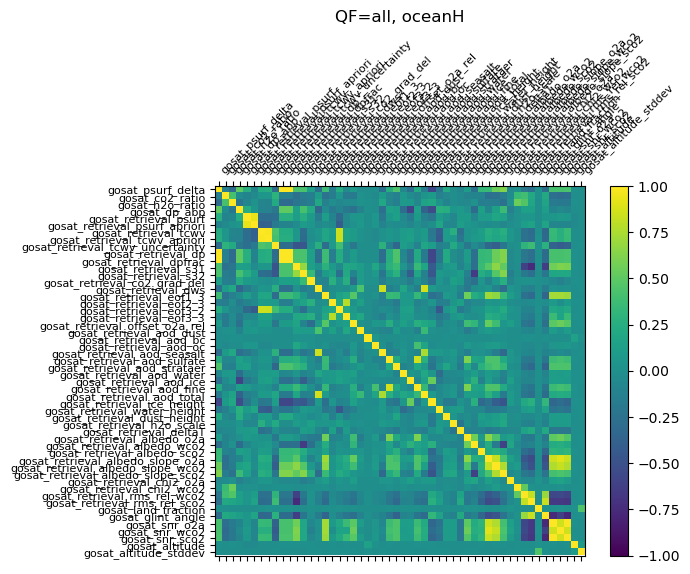

In [137]:
# Plot all correlations - rather dense plot, not all too useful
correlations = x_train[features].corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(features),1)

ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_yticklabels(features, fontsize=8)
ax.set_xticklabels(features, rotation=(45), fontsize=8, va='bottom', ha='left')

plt.title(model_string + ', ' + surface_type_string + gain_string)
plt.show()

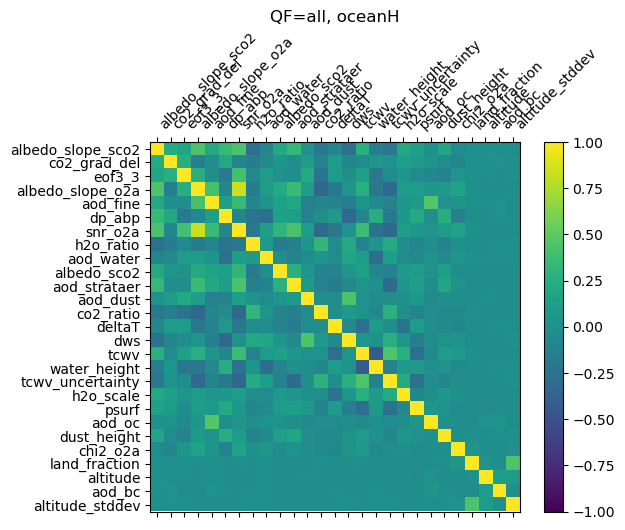

In [139]:
# Plot correlations of the reduced feature set
# Visually make sure none of the features appear to have correlations > 0.5 or < -0.5
correlations = data_df[feature_set].corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(feature_set),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_yticklabels(feature_set_string)
ax.set_xticklabels(feature_set_string, rotation=(45), fontsize=10, va='bottom', ha='left')

plt.title(model_string + ', ' + surface_type_string + gain_string)
if save_plots:
    plt.savefig(os.path.join(plot_dir, f'feature_correlations_{surface_type_string + gain_string}_{model_string}_rmse.png'), bbox_inches='tight')

plt.show()

In [140]:
# save results in dataframe
f = feautre_metrics.values()
feature_results = np.array([[f, feautre_metrics[f]['mse'], feautre_metrics[f]['mae'], feautre_metrics[f]['r2']] for f in feature_set])
feature_selection_df = pd.DataFrame(feature_results, columns=['feature', 'mse', 'mae', 'r2']) #, 'rank'])
feature_selection_df['rank'] = np.arange(feature_selection_df.shape[0])
feature_selection_df

,feature,mse,mae,r2,rank
0,gosat_retrieval_albedo_slope_sco2,2.8388595491564677,1.1957405132825518,0.21620805470350452,0
1,gosat_retrieval_co2_grad_del,1.8807055691193078,0.995770635593605,0.4813604167071201,1
2,gosat_retrieval_eof3_3,1.367675199356193,0.8567345194690169,0.6191411602588934,2
3,gosat_retrieval_albedo_slope_o2a,1.1887768304545911,0.8102834336723574,0.6671417315438555,3
4,gosat_retrieval_aod_fine,1.1234698082954322,0.7823556687914492,0.6845624335975498,4
5,gosat_dp_abp,1.056523470070867,0.7605844610763361,0.7039213363788336,5
6,gosat_snr_o2a,1.02174067790559,0.7504003092559733,0.7131566358156257,6
7,gosat_h2o_ratio,1.0190579593857443,0.7502545655015307,0.7137600916406128,7
8,gosat_retrieval_aod_water,0.9942972904303431,0.7428169833718904,0.7209110331452371,8
9,gosat_retrieval_albedo_sco2,0.9936301630042393,0.7430679404365846,0.720621630530623,9


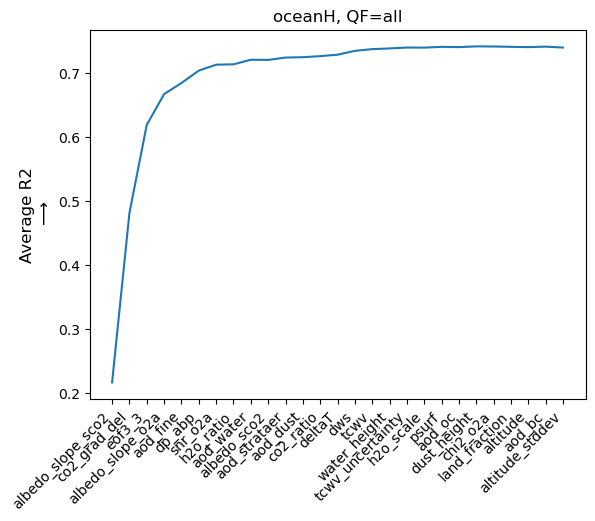

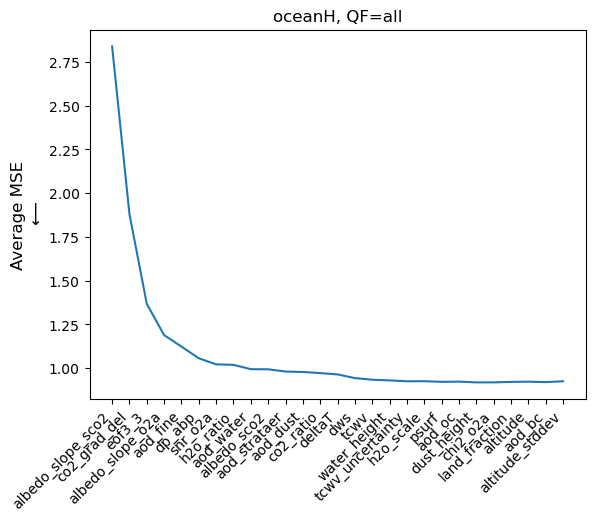

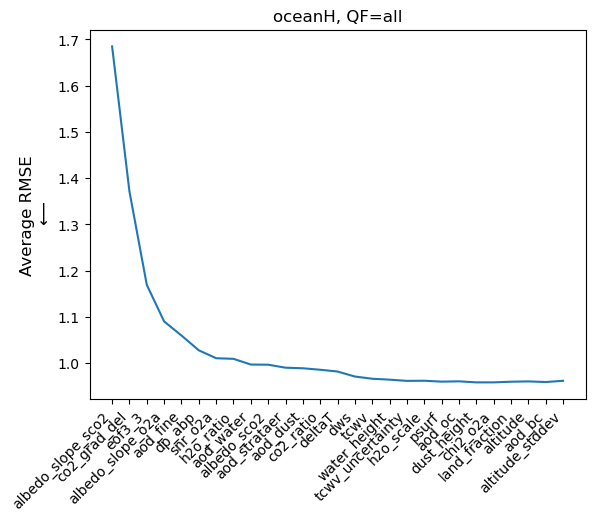

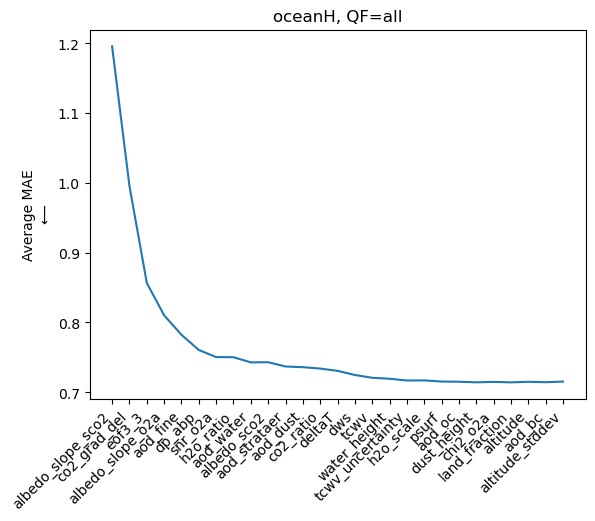

In [141]:
# Plot eval metrics as features are added, plots start with single, most important, feature and then 
# sequentially start adding features to the set.

fig, ax = plt.subplots()
ax.plot(feature_selection_df['rank'].values, feature_selection_df['r2'].values.astype(np.float32))
ticks = np.arange(0,feature_selection_df.shape[0],1)
ax.set_xticks(ticks)
ax.set_xticklabels(feature_set_string, rotation = (45), fontsize = 10,  ha='right')
#plt.annotate('2% drop', xy=(18, 0.60), xytext=(17, 0.58), arrowprops=None)
#plt.annotate('4% drop', xy=(12, 0.59), xytext=(12, 0.57), arrowprops=None)
#plt.xlabel('features')
ax.set_ylabel('Average R2\n' + r'$\longrightarrow$', fontsize=12)
plt.title(surface_type_string + gain_string + ', ' + model_string)
if save_plots:
    plt.savefig(os.path.join(plot_dir, f'feature_importance_{surface_type_string + gain_string}_{model_string}_r2.png'), bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
ax.plot(feature_selection_df['rank'].values, feature_selection_df['mse'].values.astype(np.float32))
ticks = np.arange(0,feature_selection_df.shape[0],1)
ax.set_xticks(ticks)
ax.set_xticklabels(feature_set_string, rotation=(45), fontsize=10,  ha='right')
#plt.plot(14, 0.60, 'ro', ms = 3)
#plt.annotate('1.6% drop', xy=(14, 0.60), xytext=(13.5, 0.58), arrowprops=None)
#plt.plot(19, 0.61, 'ro', ms = 3)
#plt.annotate('0% drop', xy=(19, 0.61), xytext=(18, 0.59), arrowprops=None)
#plt.xlabel('features')
ax.set_ylabel('Average MSE\n' + r'$\longleftarrow$', fontsize=12)
plt.title(surface_type_string + gain_string + ', ' + model_string)
if save_plots:
    plt.savefig(os.path.join(plot_dir, f'feature_importance_{surface_type_string + gain_string}_{model_string}_mse.png'), bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
ax.plot(feature_selection_df['rank'].values, np.sqrt(feature_selection_df['mse'].values.astype(np.float32)))
ticks = np.arange(0,feature_selection_df.shape[0],1)
ax.set_xticks(ticks)
ax.set_xticklabels(feature_set_string, rotation=(45), fontsize=10,  ha='right')
#plt.plot(14, 0.60, 'ro', ms = 3)
#plt.annotate('1.6% drop', xy=(14, 0.60), xytext=(13.5, 0.58), arrowprops=None)
#plt.plot(19, 0.61, 'ro', ms = 3)
#plt.annotate('0% drop', xy=(19, 0.61), xytext=(18, 0.59), arrowprops=None)
#plt.xlabel('features')
ax.set_ylabel('Average RMSE\n' + r'$\longleftarrow$', fontsize=12)
plt.title(surface_type_string + gain_string + ', ' + model_string)
if save_plots:
    plt.savefig(os.path.join(plot_dir, f'feature_importance_{surface_type_string + gain_string}_{model_string}_rmse.png'), bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
ax.plot(feature_selection_df['rank'].values, feature_selection_df['mae'].values.astype(np.float32))
ticks = np.arange(0,feature_selection_df.shape[0],1)
ax.set_xticks(ticks)
ax.set_xticklabels(feature_set_string, rotation=(45), fontsize=10,  ha='right')
#plt.plot(14, 0.60, 'ro', ms = 3)
#plt.annotate('1.6% drop', xy=(14, 0.60), xytext=(13.5, 0.58), arrowprops=None)
#plt.plot(19, 0.61, 'ro', ms = 3)
#plt.annotate('0% drop', xy=(19, 0.61), xytext=(18, 0.59), arrowprops=None)
#plt.xlabel('features')
ax.set_ylabel('Average MAE\n' + r'$\longleftarrow$', fontsize=10)
plt.title(surface_type_string + gain_string + ', ' + model_string)
if save_plots:
    plt.savefig(os.path.join(plot_dir, f'feature_importance_{surface_type_string + gain_string}_{model_string}_mae.png'), bbox_inches='tight')
plt.show()
